In [1]:
# Import statements

import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Data dictionary just for my own sanity

data_dict = {'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 's': 'sunken', 'p': 'spherical', 'o': 'others'},
             'cap-surface': {'i': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth', 'd': 'dry', 'h': 'shiny', 'l': 'leathery', 'k': 'sikly', 
                             't': 'sticky', 'w': 'wrinkled', 'e': 'fleshy'},
             'stem-root': {'b': 'bulbous', 's': 'swollen', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rizhomorphs', 'r': 'rooted'},
             'ring-type': {'c': 'cobwebby', 'e': 'evanexcent', 'r': 'flaring', 'g': 'grooved', 'l': 'large', 'p': 'pendant', 's': 'sheathing', 
                           'z': 'zone', 'y': 'scaly', 'm': 'movable', 'f': 'none', '?': 'unknown'},
             'season': {'s': 'spring', 'u': 'summer', 'a': 'autumn', 'w': 'winter'},
             'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'h': 'heaths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}}

In [3]:
# Reading in data from CSV

mushroom_baseDF= pd.read_csv('mushroom_overload.csv', low_memory=False)

In [4]:
# Getting a look at the different columns available

print(f"Columns: {mushroom_baseDF.columns}", "\n")
print(f"DataFrame shape: {mushroom_baseDF.shape}")

Columns: Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object') 

DataFrame shape: (6723116, 21)


In [5]:
# Simple for loop to output the number of null values in each feature

for i in mushroom_baseDF.columns:
    print(f"Number of null-values in {i}: {mushroom_baseDF[i].isnull().sum().sum()}")

Number of null-values in class: 0
Number of null-values in cap-diameter: 0
Number of null-values in cap-shape: 0
Number of null-values in cap-surface: 1579337
Number of null-values in cap-color: 0
Number of null-values in does-bruise-or-bleed: 0
Number of null-values in gill-attachment: 1066721
Number of null-values in gill-spacing: 2800709
Number of null-values in gill-color: 0
Number of null-values in stem-height: 0
Number of null-values in stem-width: 0
Number of null-values in stem-root: 5763499
Number of null-values in stem-surface: 4263506
Number of null-values in stem-color: 0
Number of null-values in veil-type: 6367343
Number of null-values in veil-color: 5893024
Number of null-values in has-ring: 0
Number of null-values in ring-type: 276729
Number of null-values in spore-print-color: 6049365
Number of null-values in habitat: 0
Number of null-values in season: 0


In [6]:
# Slimming down the dataframe into a new one to only have the relavent data

mushroom_DF = mushroom_baseDF[['cap-shape', 'cap-surface', 'stem-root', 'ring-type', 'season', 'habitat']]
mushroom_DF.head()

,cap-shape,cap-surface,stem-root,ring-type,season,habitat
0,f,g,s,g,a,d
1,x,h,s,g,u,d
2,f,h,s,p,a,d
3,f,g,s,g,u,d
4,x,h,s,p,w,d


In [7]:
'''
Dropping all rows with null values. Since I am testing if the selected categorical variables can be used to predict the dependent variable,
I am only interested in rows in which all variables are filled out.
'''

mushroom_DF_cleaned = mushroom_DF.dropna(axis = 0, how = 'any')

In [8]:
# Checking the shape

mushroom_DF_cleaned.shape

(643352, 6)

In [9]:
# Checking again for null values

for i in mushroom_DF_cleaned.columns:
    print(f"Number of null-values in {i}: {mushroom_DF_cleaned[i].isnull().sum().sum()}")

Number of null-values in cap-shape: 0
Number of null-values in cap-surface: 0
Number of null-values in stem-root: 0
Number of null-values in ring-type: 0
Number of null-values in season: 0
Number of null-values in habitat: 0


In [10]:
# Breaking the DataFrame into independent and dependent variables

X = mushroom_DF_cleaned[['cap-shape', 'cap-surface', 'stem-root', 'ring-type', 'season']]
y = mushroom_DF_cleaned[['habitat']]

In [11]:
# Using label encoding on the dependent variable and printing out the encoding mapping.

label_encoder = LabelEncoder()
y.loc[:, 'habitat'] = label_encoder.fit_transform(y['habitat']) 
print("Original categories and their encoded values:", dict(enumerate(label_encoder.classes_)))

Original categories and their encoded values: {0: 'd', 1: 'g', 2: 'h', 3: 'l', 4: 'm'}


habitat
0    475778
4     68990
3     49271
1     29625
2     19688
Name: count, dtype: int64


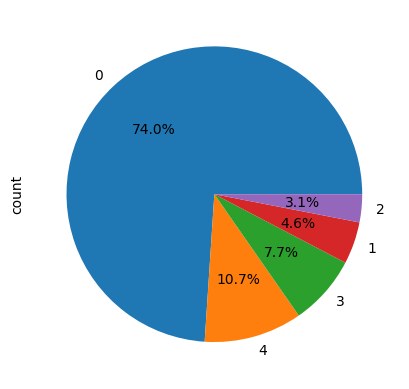

In [12]:
'''
Looking at the y-value spread. 0, which corresponds to d;woods, is highly overrepresented.
I found this while trying to fit the model originally, and had to perform more preprocessing.
'''

print(y['habitat'].value_counts())
y['habitat'].value_counts().plot.pie(autopct='%1.1f%%');

In [13]:
''' 
Flattens dataframe into 1-D array and makes sure values are INT. This is another issue I ran into while trying to fit the model.
The flattening was just to fix a warning, but for some reason the encoder was not changing the dtype of everything, causing an issue. I carte-blanch
changed everything to INT to make it all discrete values. This also needs to be done before the following UnderSampling because the undersampler will 
complain about the same issue as the model.
'''

y = y[['habitat']].values.flatten()
y = y.astype(int)

In [14]:
# Undersampling the data to cut everything down to the size of the minority label
rus = RandomUnderSampler(sampling_strategy='not minority')
X, y = rus.fit_resample(X, y)

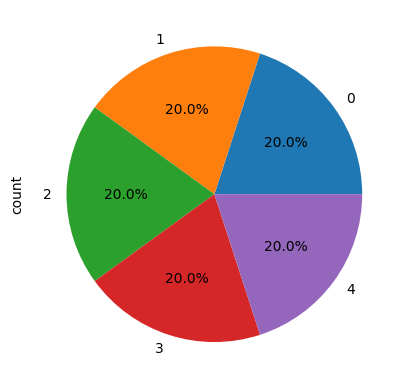

In [15]:
# Looking at the spread of the data another time to make sure that all is even.

y_series = pd.Series(y)
y_series.value_counts().plot.pie(autopct='%1.1f%%');

In [16]:
# Creating dummy variables for the non-binary, categorical independent variables.

X = pd.get_dummies(X)
X_array = X.to_numpy()

In [17]:
# Creating K-folds and splitting data

kf = KFold(n_splits=10, shuffle=True, random_state=42)
data_split_object = kf.split(X_array, y)

In [18]:
# Just visualizing the split

my_split_data = next(data_split_object)
print("Train indicies are: ", my_split_data[0][0:10])
print("Test indicies are: ", my_split_data[1][0:10])

Train indicies are:  [0 1 2 3 4 5 6 7 8 9]
Test indicies are:  [ 23  53  70  87  97 101 102 103 106 114]


In [19]:
# Empty lists that are going to store accuracy values

predicted_y = []
expected_y = []

In [20]:
'''
This FOR loop is doing a number of things:
    1. Splits data into K-folds.
    2. Creates the training and testing data-split off the data from each fold.
    3. Fit the model off the train data.
    4. Predicts the label from X_test using the trained model.
    5. Compares the predicted with the actual value in y_test.
    6. Saves the predicted and expected to the respective lists.
'''

for train_index, test_index in kf.split(X_array, y):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y[train_index], y[test_index]


    classifier = LogisticRegression(solver='saga', random_state=42)
    classifier.fit(X_train, y_train)

    predicted_this_fold = classifier.predict(X_test)

    # Leaving this in since I was using this to troubleshoot unbalanced data
    #print("y_test unique values:", np.unique(y_test), "Type:", type(y_test[0]))
    #print("predicted_this_fold unique values:", np.unique(predicted_this_fold), "Type:", type(predicted_this_fold[0]))

    accuracy = accuracy_score(y_test, predicted_this_fold)
    print("Accuracy from this fold is: " + accuracy.__str__())

    predicted_y.extend(predicted_this_fold)

    expected_y.extend(y_test)

Accuracy from this fold is: 0.8674319382364892
Accuracy from this fold is: 0.8755587159691183
Accuracy from this fold is: 0.8697683868346201
Accuracy from this fold is: 0.8715969118244616
Accuracy from this fold is: 0.8758634701340918
Accuracy from this fold is: 0.8713937423811459
Accuracy from this fold is: 0.8707842340511986
Accuracy from this fold is: 0.8669240146281999
Accuracy from this fold is: 0.8720032507110931
Accuracy from this fold is: 0.8729175132060139


In [21]:
# Final thing is to calculate and print the accuracy score for all folds.

accuracy = accuracy_score(expected_y, predicted_y)
print('\n', "Accuracy from all folds is: " + accuracy.__str__())


 Accuracy from all folds is: 0.8714242177976432
